In [ ]:
#1D CNN
#importing neccessary library
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Embedding

# Load the dataset
data = pd.read_csv("mergecsv.csv")

# Pre-processing
data['Input'] = data['Input'].apply(lambda x: x.lower().strip() if isinstance(x, str) else str(x))
X_train, X_test, y_train, y_test = train_test_split(data['Input'], data['label'], test_size=0.2, random_state=42)

# Word Embedding
sentences = [sentence.split() for sentence in X_train]
embedding_model = Word2Vec(sentences, vector_size=150, window=15, sg=1, epochs=15, min_count=1)  # Ensure all words are included
word_vectors = embedding_model.wv
vocab_size = len(word_vectors)

# Convert words to indices, handling out-of-vocabulary words
def get_word_index(word):
    try:
        return word_vectors.key_to_index[word]
    except KeyError:
        return 0  # Use index 0 for out-of-vocabulary words

X_train_indices = [[get_word_index(word) for word in sentence.split()] for sentence in X_train]
X_test_indices = [[get_word_index(word) for word in sentence.split()] for sentence in X_test]

# Pad sequences to ensure uniform length
max_length = 227
X_train_pad = pad_sequences(X_train_indices, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_indices, maxlen=max_length, padding='post')

# Reshape input data to add channel dimension
X_train_pad = np.expand_dims(X_train_pad, axis=-1)
X_test_pad = np.expand_dims(X_test_pad, axis=-1)

from keras.layers import Conv1D, MaxPooling1D  # Import Conv1D

# Build 1D CNN model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=150, input_length=max_length))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))  # Use Conv1D instead of Conv2D
model.add(MaxPooling1D(pool_size=2))  # Use MaxPooling1D instead of MaxPooling2D
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

# Filter out unexpected string values from y_train and y_test
y_train_filtered = y_train[~y_train.str.contains(r'\D', na=False)]
y_test_filtered = y_test[~y_test.str.contains(r'\D', na=False)]

# Convert labels to integers
y_train = y_train_filtered.astype(int)
y_test = y_test_filtered.astype(int)

# Check the unique values again
print("Unique values in y_train:", np.unique(y_train))
print("Unique values in y_test:", np.unique(y_test))

# Check the shapes of the input data and labels
print("Shape of X_train_pad:", X_train_pad.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test_pad:", X_test_pad.shape)
print("Shape of y_test:", y_test.shape)

# Ensure that the input data and labels have the same number of samples
min_samples = min(len(X_train_pad), len(y_train), len(X_test_pad), len(y_test))
X_train_pad = X_train_pad[:min_samples]
y_train = y_train[:min_samples]
X_test_pad = X_test_pad[:min_samples]
y_test = y_test[:min_samples]

# Check the shapes again to confirm that they match
print("Shape of X_train_pad:", X_train_pad.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test_pad:", X_test_pad.shape)
print("Shape of y_test:", y_test.shape)

# Compile and train the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train_pad, y_train, epochs=10, batch_size=32, validation_data=(X_test_pad, y_test))







Unique values in y_train: [0 1]
Unique values in y_test: [0 1]
Shape of X_train_pad: (54559, 227, 1)
Shape of y_train: (54555,)
Shape of X_test_pad: (13640, 227, 1)
Shape of y_test: (13639,)
Shape of X_train_pad: (13639, 227, 1)
Shape of y_train: (13639,)
Shape of X_test_pad: (13639, 227, 1)
Shape of y_test: (13639,)
Epoch 1/10
427/427 [==============================] - 60s 138ms/step - loss: 0.1667 - accuracy: 0.9298 - val_loss: 2.5901 - val_accuracy: 0.6718
Epoch 2/10
427/427 [==============================] - 59s 139ms/step - loss: 0.0218 - accuracy: 0.9934 - val_loss: 3.4492 - val_accuracy: 0.6736
Epoch 3/10
427/427 [==============================] - 65s 152ms/step - loss: 0.0044 - accuracy: 0.9988 - val_loss: 4.0151 - val_accuracy: 0.6734
Epoch 4/10
427/427 [==============================] - 59s 138ms/step - loss: 0.0017 - accuracy: 0.9998 - val_loss: 4.2433 - val_accuracy: 0.6734
Epoch 5/10
427/427 [==============================] - 60s 140ms/step - loss: 9.4806e-04 - accuracy: 0

In [ ]:
#2D CNN simple(with single cnn and maxpooling layer)
#importing neccessary library
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Step 1: Data Preprocessing
data = pd.read_csv('mergecsv.csv')

# Handle corner cases in the 'label' column
def convert_to_int(label):
    try:
        return int(label)
    except ValueError:
        return -1  # Handle unexpected values by assigning a default label

data['Input'] = data['Input'].apply(lambda x: str(x).lower().strip())
data['label'] = data['label'].apply(convert_to_int)
data = data[data['label'] != -1]  # Remove rows with unexpected values
X = data['Input']
y = data['label']

# Step 2: Tokenization and Padding
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X_indices = tokenizer.texts_to_sequences(X)
X_pad = pad_sequences(X_indices)

# Step 3: Reshaping for 2D CNN
max_length = X_pad.shape[1]
num_features = 1  # Since each word is represented by a single index
X_pad = X_pad.reshape(X_pad.shape[0], max_length, num_features, 1)  # Reshape for Conv2D input

# Step 4: Building the 2D CNN Model
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3, 1), activation='relu', input_shape=(max_length, num_features, 1)))
model.add(MaxPooling2D(pool_size=(2, 1)))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

# Step 5: Compiling and Training the Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
1705/1705 [==============================] - 22s 12ms/step - loss: 14.1646 - accuracy: 0.8001 - val_loss: 4.3212 - val_accuracy: 0.8174
Epoch 2/10
1705/1705 [==============================] - 21s 12ms/step - loss: 2.7096 - accuracy: 0.8426 - val_loss: 2.0896 - val_accuracy: 0.8457
Epoch 3/10
1705/1705 [==============================] - 18s 11ms/step - loss: 1.5990 - accuracy: 0.8495 - val_loss: 0.9297 - val_accuracy: 0.8605
Epoch 4/10
1705/1705 [==============================] - 21s 12ms/step - loss: 0.9554 - accuracy: 0.8616 - val_loss: 0.9007 - val_accuracy: 0.8537
Epoch 5/10
1705/1705 [==============================] - 20s 11ms/step - loss: 0.4776 - accuracy: 0.8810 - val_loss: 0.2920 - val_accuracy: 0.8843
Epoch 6/10
1705/1705 [==============================] - 19s 11ms/step - loss: 0.3339 - accuracy: 0.8843 - val_loss: 0.2596 - val_accuracy: 0.8985
Epoch 7/10
1705/1705 [==============================] - 20s 11ms/step - loss: 0.3116 - accuracy: 0.8874 - val_loss: 0.3605 

Epoch 1/10
1705/1705 [==============================] - 27s 16ms/step - loss: 0.2656 - accuracy: 0.8992 - val_loss: 0.2388 - val_accuracy: 0.8993
Epoch 2/10
1705/1705 [==============================] - 20s 12ms/step - loss: 0.2589 - accuracy: 0.9008 - val_loss: 0.2453 - val_accuracy: 0.9036
Epoch 3/10
1705/1705 [==============================] - 19s 11ms/step - loss: 0.2529 - accuracy: 0.9026 - val_loss: 0.2105 - val_accuracy: 0.9141
Epoch 4/10
1705/1705 [==============================] - 20s 12ms/step - loss: 0.2520 - accuracy: 0.9023 - val_loss: 0.2049 - val_accuracy: 0.9254
Epoch 5/10
1705/1705 [==============================] - 20s 12ms/step - loss: 0.2454 - accuracy: 0.9055 - val_loss: 0.2435 - val_accuracy: 0.8966
Epoch 6/10
1705/1705 [==============================] - 22s 13ms/step - loss: 0.2314 - accuracy: 0.9097 - val_loss: 0.2415 - val_accuracy: 0.9087
Epoch 7/10
1705/1705 [==============================] - 19s 11ms/step - loss: 0.2328 - accuracy: 0.9091 - val_loss: 0.2075 -

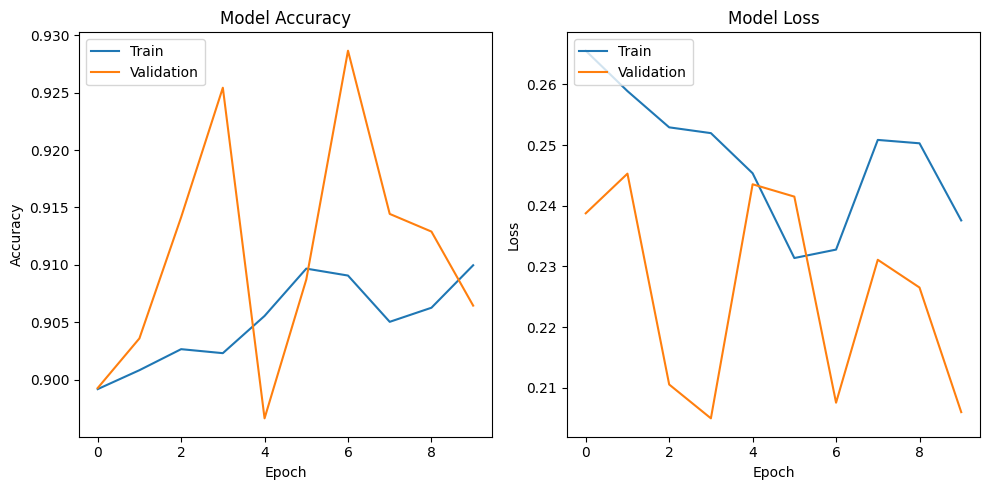

427/427 [==============================] - 2s 4ms/step - loss: 0.2060 - accuracy: 0.9064
Test Loss: 0.20596684515476227
Test Accuracy: 0.9064447283744812


In [ ]:
#plotting the model loss and model accuracy graph
import matplotlib.pyplot as plt

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Plot training history
def plot_history(history):
    plt.figure(figsize=(10, 5))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

plot_history(history)

# Evaluate model on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
